In [ ]:
import sys

# New Section

In [ ]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
#sys.path += ['/content/drive/My Drive/cm146-2024-homeworks/PS1'] # example path
sys.path += ['/content/drive/My Drive/UCLA/Winter 2024/CSM146/Problem Set 1/Problem 4/'] # your path

### ========== TODO : END ========== ###


In [ ]:
from nutil import *

In [ ]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [ ]:
######################################################################
# Immutable classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [ ]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = {}

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        self.probabilities_[0] = Counter(y)[0]/(Counter(y)[0] + Counter(y)[1])
        self.probabilities_[1] = Counter(y)[1]/(Counter(y)[0] + Counter(y)[1])
        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)

        # get n and d
        n, d = X.shape

        # make a list of probabilities
        probabilities = [self.probabilities_[0], self.probabilities_[1]]

        # get a random choice from the probabilities
        y = np.random.choice(2, (n, ), p = probabilities)

        ### ========== TODO : END ========== ###

        return y


In [ ]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [ ]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use train_test_split (be careful of the parameters)

    # use stratified shuffle split over ntrials
    ss_split = StratifiedShuffleSplit(n_splits = ntrials, test_size = test_size, random_state = 0)

    # get accumulators set up
    acc_train = 0
    acc_test  = 0
    acc_f1    = 0

    # get train and test
    for train, test in ss_split.split(X,y):
      # fit to training data
      clf.fit(X[train], y[train])

      # predict from the test data
      y_pred_train  = clf.predict(X[train])
      y_pred_test   = clf.predict(X[test])

      y_train_pred  = clf.predict(X[train])
      y_test_pred   = clf.predict(X[test])

      # get the testing error and add to accumulators
      acc_test  += 1 - metrics.accuracy_score(y[test], y_pred_test, normalize = True)
      acc_train += 1 - metrics.accuracy_score(y[train], y_pred_train, normalize = True)
      acc_f1    += metrics.f1_score(y[test], y_pred_test, average = "micro")

    # set up return values
    train_error = acc_train / ntrials
    test_error  = acc_test  / ntrials
    f1_score    = acc_f1    / ntrials

    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score

In [ ]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()

Plotting...
Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	--training error: 0.374
Classifying using Decision Tree...
	--training error: 0.0
Classifying using k-Nearest Neighbors...
	--training error k = 3 : 0.11399999999999999
	--training error k = 5 : 0.129
	--training error k = 7 : 0.15200000000000002
Investigating various classifiers...
Majority:	 train error =	 0.2399999999999996
Majority:	 test error =	 0.2399999999999996
Majority:	 F1 score =	 0.7600000000000002
Random:		 train error =	 0.37477500000000014
Random:		 test error =	 0.38199999999999984
Random:		 F1 score =	 0.6180000000000002
Decision Tree:	 train error =	 0.0
Decision Tree:	 test error =	 0.20519999999999994
Decision Tree:	 F1 score =	 0.7947999999999996
KNN:		 train error =	 0.13265000000000002
KNN:		 test error =	 0.20900000000000005
KNN:		 F1 score =	 0.7910000000000004
Finding the best k...
k: 1, validation error: 0.2350000000000001
k: 3, validation error: 0.217999999

<Figure size 640x480 with 0 Axes>

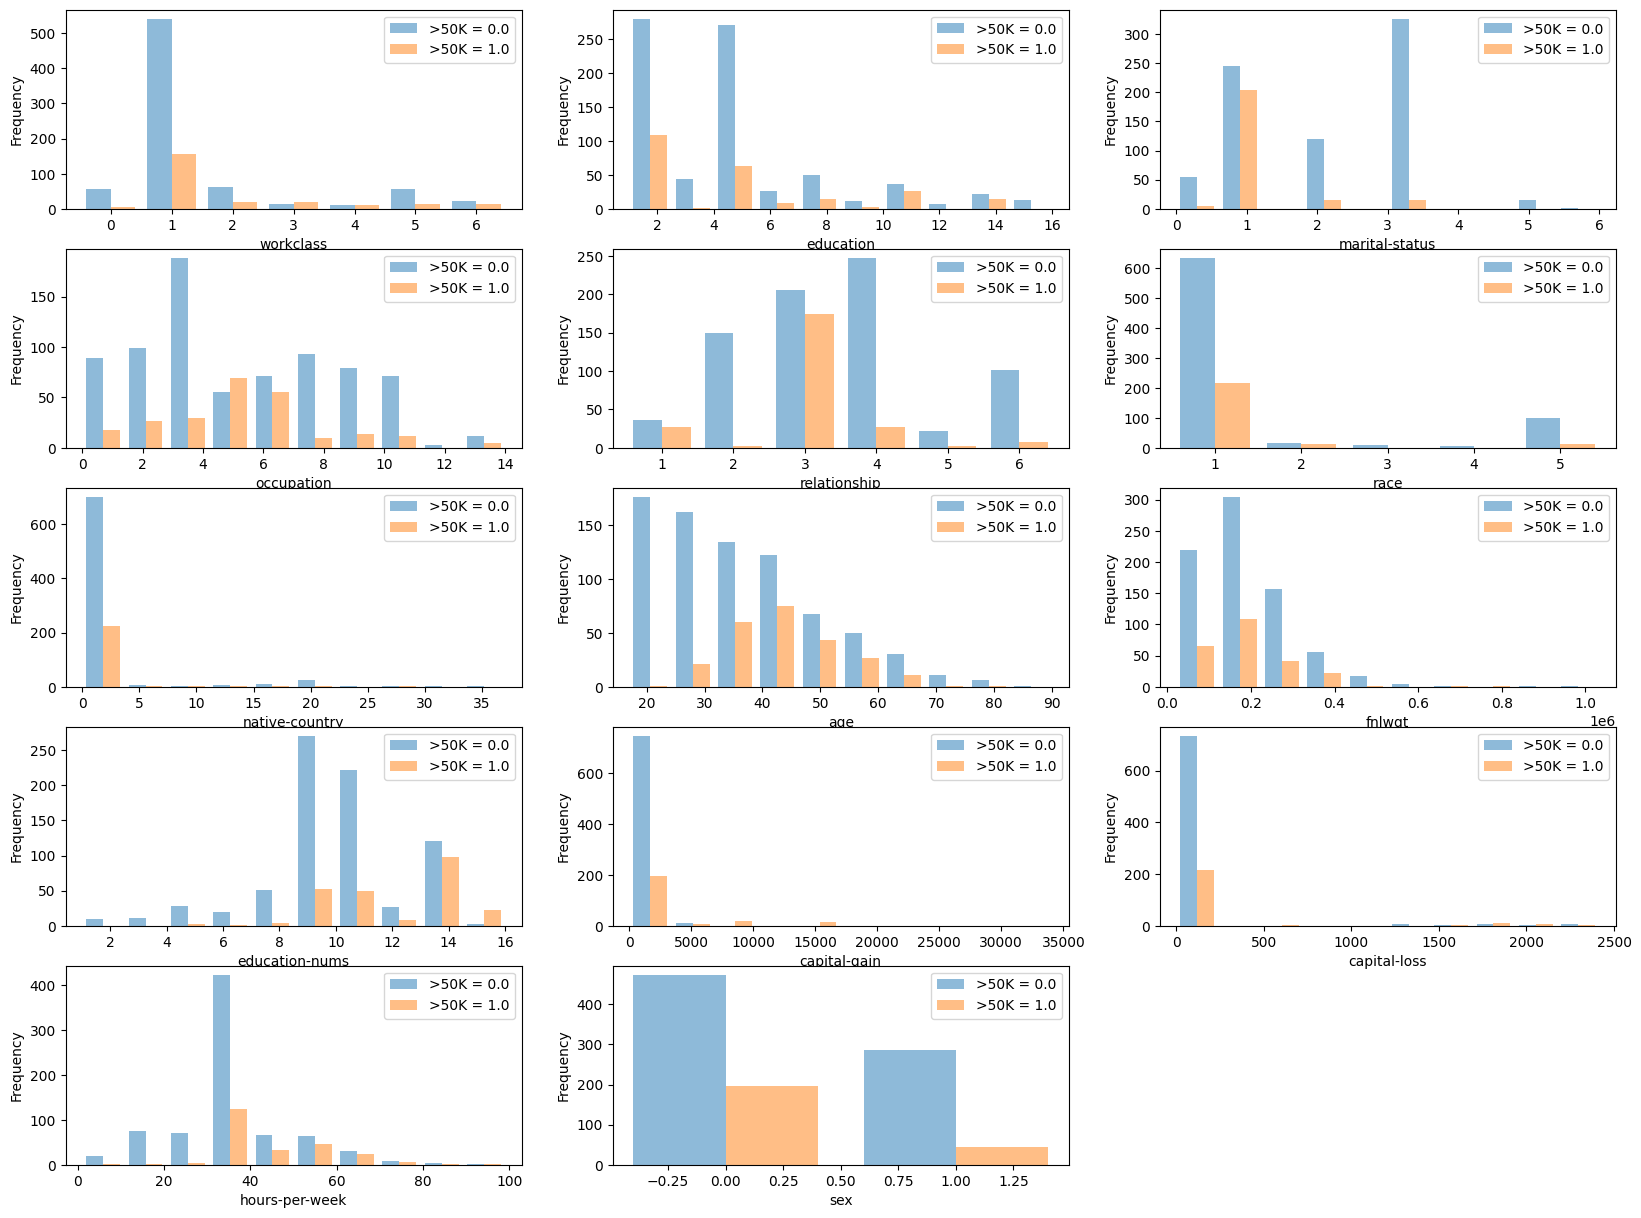

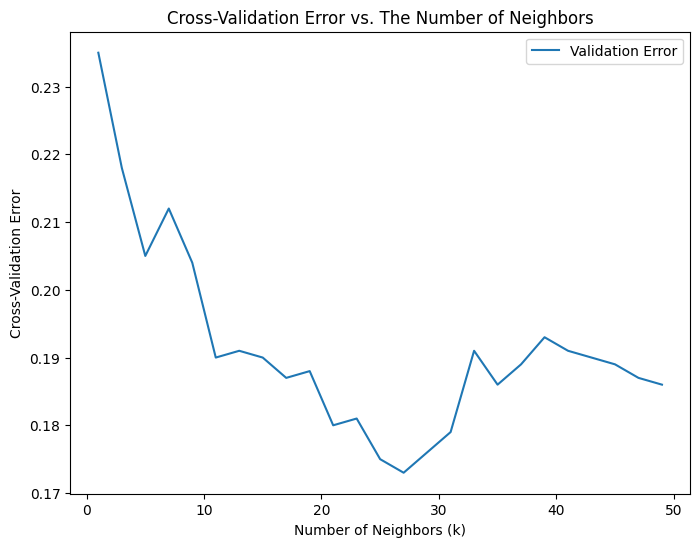

Investigating depths...


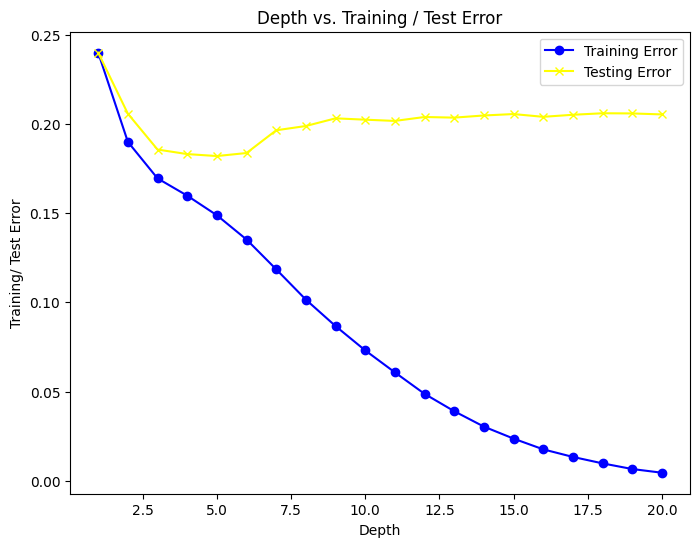

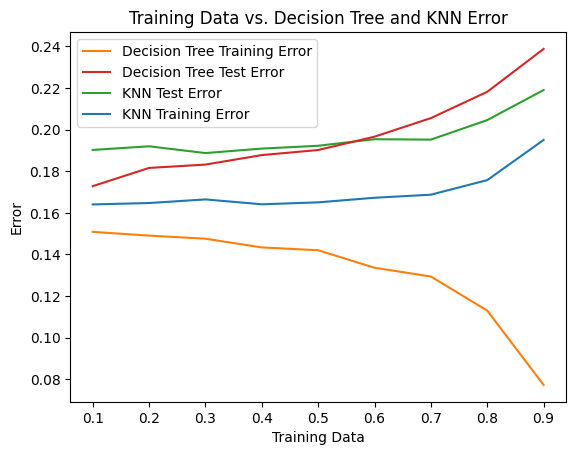

Done


In [ ]:
def main():




    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file = "/content/drive/My Drive/UCLA/Winter 2024/CSM146/Problem Set 1/Problem 4/adult_subsample.csv" # your path
    ### ========== TODO : END ========== ###




    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features



    plt.figure()
    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)





    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)

    ss = StandardScaler()
    X = ss.fit_transform(X)

    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')

    # make a random classifier and fit it to X and y
    random_classifier = RandomClassifier()

    # fit training data using the classifier
    random_classifier.fit(X,y)

    # take the classifier and run it on the training data
    y_pred = random_classifier.predict(X)

    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize = True)
    print("\t--training error: " + str(train_error))
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')

    # make a decision tree with entropy criterion
    d_tree = DecisionTreeClassifier(criterion = "entropy")

    # fit training data using the classifier
    d_tree.fit(X,y)

    # take the classifier and run it on the training data
    y_pred = d_tree.predict(X)

    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print("\t--training error: " + str(train_error))
    ### ========== TODO : END ========== ###






    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')

    # create k-Nearest Neighbors classifier for 3, 5, 7
    knn_3 = KNeighborsClassifier(n_neighbors = 3)
    knn_5 = KNeighborsClassifier(n_neighbors = 5)
    knn_7 = KNeighborsClassifier(n_neighbors = 7)

    # fit training data using the classifier
    knn_3.fit(X,y)
    knn_5.fit(X,y)
    knn_7.fit(X,y)

    # take the classifier and run it on the training data
    y_pred_3 = knn_3.predict(X)
    y_pred_5 = knn_5.predict(X)
    y_pred_7 = knn_7.predict(X)

    train_error_3 = 1 - metrics.accuracy_score(y, y_pred_3, normalize=True)
    train_error_5 = 1 - metrics.accuracy_score(y, y_pred_5, normalize=True)
    train_error_7 = 1 - metrics.accuracy_score(y, y_pred_7, normalize=True)
    print("\t--training error k = 3 : " + str(train_error_3))
    print("\t--training error k = 5 : " + str(train_error_5))
    print("\t--training error k = 7 : " + str(train_error_7))
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    # create MajorityVote classifier, which includes all model parameters
    # make a random classifier and fit it to X and y
    # make a decision tree with entropy criterion
    # create k-Nearest Neighbors classifier for 5
    majority          = MajorityVoteClassifier()
    random_classifier = RandomClassifier()
    d_tree            = DecisionTreeClassifier(criterion = "entropy")
    knn_5             = KNeighborsClassifier(n_neighbors = 5)

    # get error for each
    majority_error          = error(majority, X, y)
    random_classifier_error = error(random_classifier, X, y)
    d_tree_error            = error(d_tree, X, y)
    knn_5_error             = error(knn_5, X, y)

    # print each
    print("Majority:\t train error =\t "      + str(majority_error[0]))
    print("Majority:\t test error =\t "       + str(majority_error[1]))
    print("Majority:\t F1 score =\t "         + str(majority_error[2]))

    print("Random:\t\t train error =\t "        + str(random_classifier_error[0]))
    print("Random:\t\t test error =\t "         + str(random_classifier_error[1]))
    print("Random:\t\t F1 score =\t "           + str(random_classifier_error[2]))

    print("Decision Tree:\t train error =\t " + str(d_tree_error[0]))
    print("Decision Tree:\t test error =\t "  + str(d_tree_error[1]))
    print("Decision Tree:\t F1 score =\t "    + str(d_tree_error[2]))

    print("KNN:\t\t train error =\t "           + str(knn_5_error[0]))
    print("KNN:\t\t test error =\t "            + str(knn_5_error[1]))
    print("KNN:\t\t F1 score =\t "              + str(knn_5_error[2]))

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')

    # set k values
    k_vals = list(range(1, 50, 2))

    # set error values for k neighbors classifier
    val_error = []
    best_k = None
    best_error = float('inf')
    for k in k_vals:
        # get a knn classifier for each k value
        clf = KNeighborsClassifier(n_neighbors=k)

        # get error values
        error_val = 1 - cross_val_score(clf, X, y, cv=10).mean()
        val_error.append(error_val)
        print(f"k: {k}, validation error: {error_val}")

        # check if the current k is the best one
        if error_val < best_error:
            best_error = error_val
            best_k = k

    # print the best k value found
    print(f"The best k value is: {best_k} with a validation error of: {best_error}")

    plt.figure(figsize=(8, 6))
    plt.plot(k_vals, val_error, label='Validation Error')
    plt.title("Cross-Validation Error vs. The Number of Neighbors")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Cross-Validation Error")
    plt.legend()
    plt.show()
    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')

    depths = list(range(1,21))
    train_errors = []
    test_errors = []
    max_depth = []

    for i in depths:
      # make a tree at each depth
      d_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = i)

      # get error values
      tmp_train_error, tmp_test_error, f1_error = error(d_tree, X, y)

      # append values
      train_errors.append(tmp_train_error)
      test_errors.append(tmp_test_error)
      max_depth.append(i)

      # print([i, tmp_test_error])

    fig = plt.figure(figsize = (8, 6)).add_subplot()
    fig.plot(max_depth, train_errors, label = "Training Error", color = "blue", marker = "o")
    fig.plot(max_depth, test_errors,  label = "Testing Error",  color = "yellow",  marker = "x")
    plt.title("Depth vs. Training / Test Error")
    plt.xlabel("Depth")
    plt.ylabel("Training/ Test Error")
    plt.legend()
    plt.show()

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes

    d_tree_test = []
    d_tree_train = []
    knn_test = []
    knn_train = []

    x_train_data = None
    x_test_data = None
    y_train_data = None
    y_test_data = None

    sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 0)
    for i, j in sss.split(X, y):
      x_train = X[i]
      x_test = X[j]
      y_train = y[i]
      y_test = y[j]

    # make a decision tree
    d_tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 5)
    d_tree.fit(x_train, y_train)

    # make a knn classifier
    knn = KNeighborsClassifier(n_neighbors = 15)
    knn.fit(x_train, y_train)

    percentages = [x/10.0 for x in range(1, 10)]

    for i in percentages:
      #get error
      d_train, d_test, f1 = error(d_tree, X, y, ntrials = 100, test_size = i)
      k_train, k_test, f1 = error(knn, X, y, ntrials = 100, test_size = i)

      #append values
      d_tree_train.append(d_train)
      d_tree_test.append(d_test)
      knn_test.append(k_test)
      knn_train.append(k_train)

    k_test_out,   = plt.plot(percentages, knn_train,    label = "KNN Training Error")
    d_train_out,  = plt.plot(percentages, d_tree_train, label = "Decision Tree Training Error")
    k_train_out,  = plt.plot(percentages, knn_test,     label = "KNN Test Error")
    d_test_out,   = plt.plot(percentages, d_tree_test,  label = "Decision Tree Test Error")


    plt.title("Training Data vs. Decision Tree and KNN Error")
    plt.xlabel("Training Data")
    plt.ylabel("Error")
    hand = [d_train_out, d_test_out, k_train_out, k_test_out]
    plt.legend(handles = hand)
    plt.show()

    ### ========== TODO : END ========== ###

    print('Done')


if __name__ == "__main__":
    main()